In [89]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import missingno as msno
from collections import defaultdict
import matplotlib as plt
import plotly.express as px
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#### Import des données

In [90]:
df = pd.read_csv('QueryResults.csv', encoding="utf-8")

<Axes: >

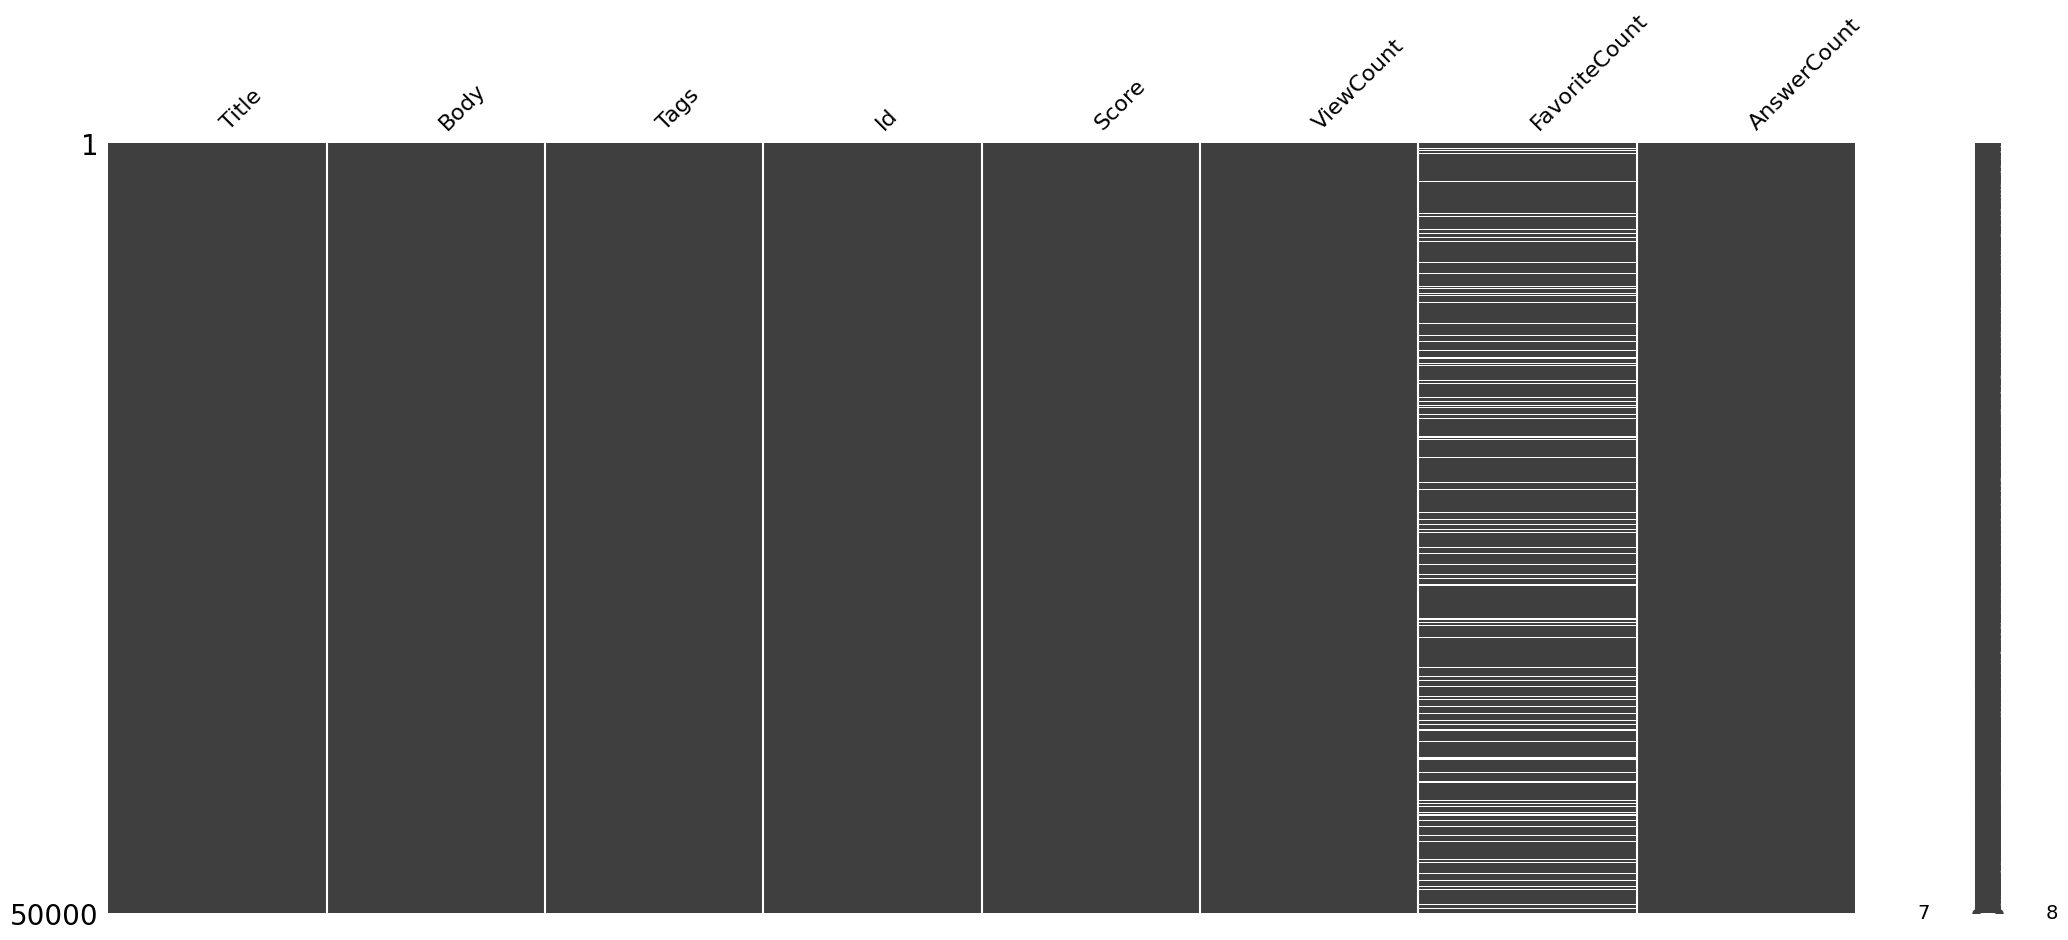

In [91]:
#Checking for NaN
%matplotlib inline
msno.matrix(df)

In [92]:
df.describe()

,Id,Score,ViewCount,FavoriteCount,AnswerCount
count,5.000000e+04,50000.000000,5.000000e+04,43243.000000,50000.000000
mean,2.476745e+07,33.789220,3.181244e+04,0.000093,3.865100
std,2.069348e+07,176.255767,1.312287e+05,0.009617,4.179686
min,4.000000e+00,6.000000,6.400000e+01,0.000000,1.000000
25%,4.165532e+06,7.000000,3.108000e+03,0.000000,2.000000
50%,2.106732e+07,10.000000,8.496500e+03,0.000000,3.000000
75%,3.982085e+07,20.000000,2.221950e+04,0.000000,5.000000
max,7.452224e+07,9185.000000,9.678908e+06,1.000000,126.000000


In [93]:
#Suppression des données inutiles
df = df.drop(columns=['FavoriteCount', 'Score', 'ViewCount', 'AnswerCount'])


In [94]:
df = df.set_index('Id')


### Définition des fonctions de nettoyage de texte

In [95]:
##Download des stopwords nltk
# nltk.download('stopwords')

In [96]:


# Tokenizer
def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('/', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')', '>', '<']\
                                               + ['like', 'use', 'using', 'want', 'way', 'strong', 'errors', 'error', 'pre', 'code']\
                                               + ['.+[1-9].+']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)


def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text


#### Nettoyage du texte

In [97]:
#Fusion des colonnes Body et Title
df['body_title'] = df['Body'] + ' ' + df['Title']
df = df.drop(columns=['Body','Title'])

In [98]:
#Supression des balises 
df['body_title'] = df['body_title'].str.replace('<pre>(.|\n)+?</pre>', '', regex=True)
df['body_title'] = df['body_title'].str.replace('<a(.|\n)+?>', '', regex=True)
df['body_title'] = df['body_title'].str.replace('<code>(.|\n)+?</code>', '', regex=True)


In [99]:
#Prévisu d'un texte sans balises
print(df.iloc[5]['body_title'])

<p>I found this example on How to refresh oauth token using moya and rxswift</a> which I had to alter slightly to get to compile. This code works 80% for my scenario. The problem with it is that it will run for all http errors, and not just 401 errors. What I want is to have all my other http errors passed on as errors, so that I can handle them else where and not swallow them here.</p>

<p>With this code, if I get a , it will run the authentication code 3 times which is obviously not what I want.</p>

<p>Ive tried to alter this code to handle only handle  errors, but it seem that no matter what I do I can't get the code to compile. It's always complaining about wrong return type,  which makes no sense to me..</p>

<p>What I want: handle 401, but stop on all other errors</p>


 Using retryWhen to update tokens based on http error code


In [100]:
#Application des fonctions de cleaning
df['Tags'] = df['Tags'].apply(lambda x: x.replace('<', '').replace('>', ' '))
df['body_title_bow'] = df['body_title'].apply(lambda x : transform_bow_fct(x))
df['tag_bow'] = df['Tags'].apply(lambda x : transform_bow_fct(x))
df = df.drop(columns=['body_title', 'Tags'])

In [101]:
# Prévisualisation d'un texte clean
print(df.iloc[5]['body_title_bow'])

found example how refresh oauth token moya rxswift alter slightly get compile this works scenario the problem run 401 what passed handle else swallow here. with get run authentication times obviously want. ive tried alter handle handle seem matter n't get compile always complaining wrong return type makes sense what handle 401 stop using retrywhen update tokens based


### Visualisations des termes les plus utilisé dans le "Body"

In [102]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
tfidf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'body_title_bow'
cv_body = cvect.fit_transform(df[feat])
tfidf_body = tfidf.fit_transform(df[feat])

# cv_transform = cvect.transform(df[feat])  
# ctf_transform = ctf.transform(df[feat])  

Selon CountVectorizer:

In [103]:
#Calcul de la fréquence des termes via countvectorizer
body_count = np.sum(cv_body, axis=0)
most_common = pd.DataFrame(body_count, columns=cvect.get_feature_names_out()).squeeze()
most_common = most_common.sort_values(ascending=False)
most_common = most_common.sort_values()

In [104]:
#Affichage des résultats du comptages via graph
df_common = most_common.tail(30)
fig = px.bar(df_common, orientation='h', labels={ "value":"fréquence totale", "index":"étiquettes" }, width=800, height=800)
fig.update_layout(showlegend=False)
fig.show()

Selon tf-idf:

In [105]:
#Comptage avec tfidf
body_count = np.sum(tfidf_body, axis=0)
most_common = pd.DataFrame(body_count, columns=tfidf.get_feature_names_out()).squeeze()
most_common = most_common.sort_values(ascending=False)
most_common = most_common.sort_values()


In [106]:
#Affichage des résultats du comptages via graph
df_common = most_common.tail(30)
fig = px.bar(df_common, orientation='h', labels={ "value":"fréquence totale", "index":"étiquettes" }, width=800, height=800)
fig.update_layout(showlegend=False)
fig.show()

### Visualisations des termes les plus utilisé dans les "Tags"

In [107]:
feat = 'tag_bow'
cv_tags = cvect.fit_transform(df[feat])

In [108]:
#Comptage des tag avec countvectorizer
tags_count = np.sum(cv_tags, axis=0)
most_common_tags = pd.DataFrame(tags_count, columns=cvect.get_feature_names_out()).squeeze()
most_common_tags = most_common_tags.sort_values(ascending=True)
df_common_tags = most_common_tags.tail(30)

In [109]:
#Affichage des résultats du comptages via graph
fig = px.bar(df_common_tags, orientation='h', labels={ "value":"fréquence totale", "index":"étiquettes" }, width=800, height=800)
fig.update_layout(showlegend=False)
fig.show()

#### Visualisation de la répartition du nombre de tag par question

In [110]:
posts_tags_tf = np.sum(cv_tags, axis=1)
posts_tags_tf = pd.DataFrame(posts_tags_tf, columns=['tag_bow'])
posts_tags_tf = posts_tags_tf.value_counts(ascending=False).sort_index()
posts_tags_tf.index = posts_tags_tf.index.get_level_values(0)

In [111]:
#Affichage des résultats du comptages via graph
fig = px.bar(posts_tags_tf, labels={ "value":"nombre de questions", "tag_bow":"nombre de tags" }, width=800, height=800)
fig.update_layout(showlegend=False)
fig.show()

In [112]:
df.to_csv('tokenized_data.csv')

In [113]:
df.head()

,body_title_bow,tag_bow
Id,,
39946022,how make horizontal scrolling collectionview f...,ios swift uicollectionview uicollectionviewcel...
57086301,tried write custom implementation basic neural...,python python 3.x tensorflow neural network te...
21965,could somebody please rundown programmatically...,.net configuration encryption configuration files
38281724,n't initialize elements element wise compatibl...,c++ templates c++11 stdtuple boost tuples
22067,has anybody used project gantt chart control y...,.net 2.0 controls project gantt chart


#### Selection des tags

In [114]:
# Selection du top 50 de nos tags
stop_tags = set(most_common_tags[:-50].index)
stop_tags = list(stop_tags)

In [115]:
#Vectorization de nos tags pour le multilabelling
cvect2 = CountVectorizer(stop_words=stop_tags, max_df=0.95, min_df=1)
vectorized_tags = cvect2.fit_transform(df['tag_bow'])
vectorized_tags = pd.DataFrame.sparse.from_spmatrix(vectorized_tags)
vectorized_tags.columns = cvect2.get_feature_names_out()

In [116]:
vectorized_tags.sum(axis=0).sort_values()


front            1
none             1
nothing          1
without          1
in               1
              ... 
javascript    5112
java          6476
android       6659
python        6900
net           8372
Length: 103, dtype: int64

In [117]:
#Suppression de tags apparu de nul part
sommes = vectorized_tags.sum(axis=0).sort_values()
columns_to_drop = sommes[sommes <= 202].index
vectorized_tags = vectorized_tags.drop(columns_to_drop, axis=1)
vectorized_tags.head()

,amazon,android,angular,apache,api,asp,azure,core,css,data,...,sql,string,studio,swift,system,testing,visual,web,windows,xcode
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [118]:
#Suppression des questions n'ayant aucun tag dans notre top 50
vectorized_tags = vectorized_tags.where(vectorized_tags < 2, 1)
nb_withouht_tags = vectorized_tags[vectorized_tags.sum(axis=1) == 0 ]
f"Sans étiquettes : {round(nb_withouht_tags.shape[0]/vectorized_tags.shape[0]*100)} %"

'Sans étiquettes : 17 %'

In [119]:
cleaned_df = df.copy()
cleaned_df = cleaned_df.iloc[vectorized_tags[vectorized_tags.sum(axis=1) != 0 ].index]
cleaned_df.shape

(41357, 2)

In [120]:
cleaned_df.head()

,body_title_bow,tag_bow
Id,,
39946022,how make horizontal scrolling collectionview f...,ios swift uicollectionview uicollectionviewcel...
57086301,tried write custom implementation basic neural...,python python 3.x tensorflow neural network te...
21965,could somebody please rundown programmatically...,.net configuration encryption configuration files
22067,has anybody used project gantt chart control y...,.net 2.0 controls project gantt chart
38281760,found example how refresh oauth token moya rxs...,ios swift alamofire swift moya


In [121]:
#Enregistrement de nos textes clean
cleaned_df['body_title_bow'].to_csv('cleaned.csv')
#Enregistrement de nos tags vectorisés
vectorized_tags[vectorized_tags.sum(axis=1) != 0].to_csv("vectorized_tags.csv", index=False)

C:\Users\Rémi\AppData\Local\Temp\ipykernel_11208\1516193598.py:4: FutureWarning:

The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`

